https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/train/cifar-10-python.tar.gz to ./CIFAR10/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/test/cifar-10-python.tar.gz to ./CIFAR10/test


(-0.5, 165.5, 165.5, -0.5)

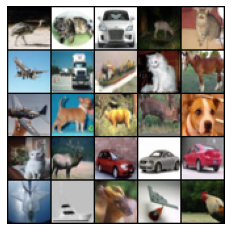

In [2]:
#Initializing normalizing transform for the dataset
normalize_transform = Compose([ToTensor(), Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])

#Downloading the CIFAR10 dataset into train and test sets
trainset = CIFAR10(root="./CIFAR10/train", train=True, transform=normalize_transform, download=True)
testset = CIFAR10(root="./CIFAR10/test", train=False, transform=normalize_transform, download=True)
trainset_size = round(len(trainset) * 0.8)
validset_size = len(trainset) - trainset_size
trainset, validset = random_split(trainset, [trainset_size, validset_size])

#Generating data loaders from the corresponding datasets
batch_size = 128
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(validset, batch_size=batch_size, shuffle=True)	
test_loader = DataLoader(testset, batch_size=batch_size)

#Plotting 25 images from the 1st batch
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.imshow(np.transpose(make_grid(images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

Text(0, 0.5, 'Number of training instances')

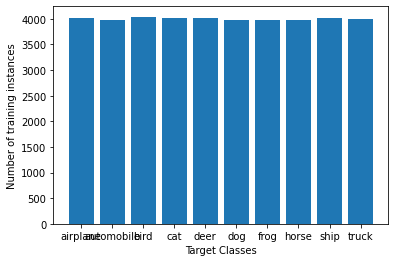

In [3]:

#Iterating over the training dataset and storing the target class for each sample
classes = []
for batch_idx, data in enumerate(train_loader, 0):
    x, y = data 
    classes.extend(y.tolist())
      
#Calculating the unique classes and the respective counts and plotting them
unique, counts = np.unique(classes, return_counts=True)
names = list(testset.class_to_idx.keys())
plt.bar(names, counts)
plt.xlabel("Target Classes")
plt.ylabel("Number of training instances")

In [4]:
class CNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.model = torch.nn.Sequential(
        #Input = 3 x 32 x 32, Output = 32 x 32 x 32
			  torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
				torch.nn.BatchNorm2d(32),
			  torch.nn.ReLU(),
			  #Input = 32 x 32 x 32, Output = 32 x 16 x 16
			  torch.nn.MaxPool2d(kernel_size=2),

			  #Input = 32 x 16 x 16, Output = 64 x 16 x 16
			  torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
			  torch.nn.BatchNorm2d(64),
				torch.nn.ReLU(),
			  #Input = 64 x 16 x 16, Output = 64 x 8 x 8
			  torch.nn.MaxPool2d(kernel_size=2),
			
			  #Input = 64 x 8 x 8, Output = 64 x 8 x 8
			  torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
			  torch.nn.BatchNorm2d(64),
				torch.nn.ReLU(),
			  #Input = 64 x 8 x 8, Output = 64 x 4 x 4
			  torch.nn.MaxPool2d(kernel_size=2),

			  torch.nn.Flatten(),
			  torch.nn.Linear(64*4*4, 512),
				torch.nn.Dropout(p=0.5),
			  torch.nn.ReLU(),
			  torch.nn.Linear(512, 10))
  
  def forward(self, x):
    return self.model(x)

In [5]:
# compute the loss on validation set for early stopping
def validation(model, device, valid_dl, criterion):
  model.eval() # Sets the module in evaluation mode
  loss_total = 0
  with torch.no_grad():
    for _, (images, labels) in enumerate(valid_dl):
      inputs = images.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss_total += loss.item()
  
  return loss_total / len(valid_dl)

In [6]:

# Training 
def train_model(model, device, epochs, optimizer, criterion, train_dl, valid_dl):
  train_loss_list = []; last_loss = 100; patience = 2; triggertimes = 0;
  for epoch in range(1,epochs+1):
		# Sets the module in traininng mode
    model.train()
    for batch_idx, (images,labels) in enumerate(train_loader):
      inputs = images.to(device)
      labels = labels.to(device)
      # Zero the gradients
      optimizer.zero_grad()
      # Forward and backward propagation
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # Show progress
      if batch_idx % 100 == 0 or batch_idx == len(train_loader):
        print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, batch_idx, len(train_dl), loss.item()))
    
    #with train_summary_writer.as_default():
      #summary.scalar('loss', loss.item(), step=epoch)

    # Early stopping
    current_loss = validation(model, device, valid_dl, criterion)
    if current_loss > last_loss:
      triggertimes += 1 
      print('trigger times', triggertimes)       
    if triggertimes >= patience:
      print('Perform Early stopping!')
      return model
    else:
      trigger_times = 0 
      print('trigger times', triggertimes)          
    last_loss = current_loss
    train_loss_list.append(last_loss/len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}")
  return model
	
	
  #Plotting loss for all epochs
  plt.plot(range(1,epochs+1), train_loss_list)
  plt.xlabel("Number of epochs")
  plt.ylabel("Training loss")

In [7]:
#Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)
summary(model,(3,32,32))
#Defining the model hyper parameters
epochs = 50
learning_rate = 0.001
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_model(model, device, epochs, optimizer, criterion, train_loader, valid_dl)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): ReLU()
    (16): Linea

In [8]:
# evaulate model on test dataset
test_acc=0
model.eval()

with torch.no_grad():
	#Iterating over the test dataset in batches
	for i, (images, labels) in enumerate(test_loader):
		
		images = images.to(device)
		y_true = labels.to(device)
		
		#Calculating outputs for the batch being iterated
		outputs = model(images)
		
		#Calculated prediction labels from models
		_, y_pred = torch.max(outputs.data, 1)
		
		#Comparing predicted and true labels
		test_acc += (y_pred == y_true).sum().item()
	
	print(f"Test set accuracy = {100 * test_acc / len(testset)} %")


Test set accuracy = 72.95 %


(-0.5, 165.5, 33.5, -0.5)

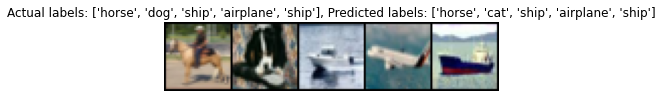

In [9]:
#Generating predictions for 'num_images' amount of images from the last batch of test set
num_images = 5
y_true_name = [names[y_true[idx]] for idx in range(num_images)]
y_pred_name = [names[y_pred[idx]] for idx in range(num_images)]

#Generating the title for the plot
title = f"Actual labels: {y_true_name}, Predicted labels: {y_pred_name}"

#Finally plotting the images with their actual and predicted labels in the title
plt.imshow(np.transpose(make_grid(images[:num_images].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
plt.title(title)
plt.axis("off")